In [1]:
import scipy.io as io
import os
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.insert(1, r'C:\Users\Vasco\Documents\Ms Data Science\3Semester\Code\EIT_CoViD_Internship')
from helper_func import *

## TEST 1
Retreive/Convert the COV077_05.mat file to an array

In [2]:
file_path = r'C:\Users\Vasco\Documents\Ms Data Science\3Semester\Code\EIT_CoViD_Internship'
filename = 'COV077_05.mat'
file_name = os.path.join(file_path,'Sample_EIT_Data',filename)
#load data
data = io.loadmat(file_name)
#extracting the structure SECTION
section = data['section'][0]
#Get a dictionary of the variable names
dict_var_section = get_dict_var_names(section)

In [3]:
print(f'The index of the variable dzMov is {dict_var_section["dzMov"]} and the PEEP level is on {str(dict_var_section["PEEP"])}.')

The index of the variable dzMov is 48 and the PEEP level is on 37.


Get image 7 from PEEP level 16

In [4]:
res=np.array([])
for i in range(8):
    temp = np.where(section[i][dict_var_section['PEEP']][0][0]==16)
    if temp[0].size>0:
        res = np.append(res,i)
print(f'The index corresponding to the PEEP level 16 is {int(res)}.')

The index corresponding to the PEEP level 16 is 4.


The difference in pixel values between the two images is 0.0.


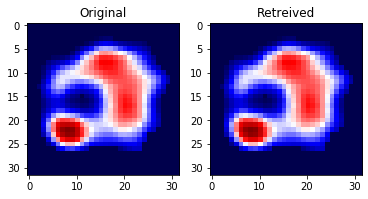

In [5]:
# Ground Truth
GT = io.loadmat('ground_truth.mat')
GT = np.reshape(GT["dzMov"][0],(32,32))
dzMov = section[4][dict_var_section['dzMov']][6]
dzMov = np.reshape(dzMov,(32,32))
plt.figure
plt.set_cmap('seismic')
plt.subplot(121)
plt.imshow(GT)
plt.title('Original')
plt.subplot(122)
plt.imshow(dzMov)
plt.title('Retreived')
print(f'The difference in pixel values between the two images is {np.sum(GT-dzMov)}.')

## TEST 2
Given that the 1st test was completed with success we will assume from now on that the retreival of the informtation from the .mat files is behaving as expected. Let's now test the different data transformation option.


In [6]:
from helper_func import norm_PEEP, img_diff

### 1st step:
Extract the frames from 2 different PEEP levels so we can test the intra-PEEP-Level normalization with one of them and test the extra-PEEP-Level normalization with both of them.

In [7]:
PEEP1 = section[4][dict_var_section['dzMov']]
PEEP2 = section[5][dict_var_section['dzMov']]
print(f'PEEP1 Shape: {PEEP1.shape}\nPEEP2 Shape: {PEEP2.shape}')

PEEP1 Shape: (43, 1024)
PEEP2 Shape: (43, 1024)


### 2nd Step - Test Intra-PEEP normalization:
1) find 1% and 99% quantile values for a particular PEEP level;
2) Compute the absolute range of values;
3) Divide/Normalize the values by the absolute range;

Q1 = 0.0
Q99 = 0.05772575646637848
Abs_Range =  0.05772575646637848


Before Thresholding:
PEEP_Max = 0.09608691920874343
PEEP_Min = -0.004921901457996955

After Thresholding:
PEEP_Max = 0.05772575646637848
PEEP_Min = 0.0

After Normalizing:
PEEP_Norm_Max = 1.0
PEEP_Norm_Min = 0.0

Example of a before and after frame:


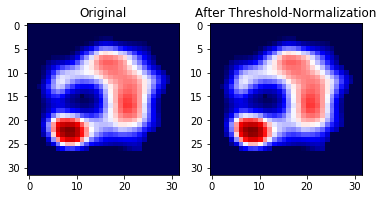

In [8]:
#finding the quantiles
q1 = np.quantile(PEEP1,0.01)
q99 = np.quantile(PEEP1,0.99)
#computing the value's range
var_range = abs(q1)+abs(q99)
print(f'Q1 = {q1}\nQ99 = {q99}\nAbs_Range =  {var_range}\n\n')
print('Before Thresholding:')
print(f'PEEP_Max = {PEEP1.max()}\nPEEP_Min = {PEEP1.min()}\n')
# Threshold to values between Q1 and Q99
PEEP1_thresh = np.clip(PEEP1.copy(), q1, q99)
print('After Thresholding:')
print(f'PEEP_Max = {PEEP1_thresh.max()}\nPEEP_Min = {PEEP1_thresh.min()}\n')
#normalize through division of every value by range
PEEP1_norm = (PEEP1_thresh.copy()-q1)/var_range
print('After Normalizing:')
print(f'PEEP_Norm_Max = {PEEP1_norm.max()}\nPEEP_Norm_Min = {PEEP1_norm.min()}\n')
print('Example of a before and after frame:')
plt.figure
plt.subplot(121)
plt.imshow(np.reshape(PEEP1[10],(32,32)))
plt.title('Original')
plt.set_cmap('seismic')
plt.subplot(122)
plt.imshow(np.reshape(PEEP1_norm[10],(32,32)))
plt.title('After Threshold-Normalization')
plt.set_cmap('seismic')

### 3rd Step - Test Extra-PEEP normalization:
1) find 1% and 99% quantile values over the entire trial;
2) Compute the absolute range of values;
3) Divide/Normalize the values by the absolute range;

iter_0: Q1:0.0 Q99:0.05772575646637848
iter_1: Q1:0.0 Q99:0.06425790948462583
Values to consider for all PEEP levels:
Q1 = 0.0
Q99 = 0.06425790948462583
Abs_Range =  0.06425790948462583


Before Thresholding:
PEEP1_Max = 0.09608691920874343
PEEP1_Min = -0.004921901457996955

PEEP2_Max = 0.10401243582609351
PEEP2_Min = -0.0015382535743166908

After Thresholding:
PEEP1_Max = 0.06425790948462583
PEEP1_Min = 0.0

PEEP2_Max = 0.06425790948462583
PEEP2_Min = 0.0

After Normalizing:
PEEP_Norm1_Max = 1.0
PEEP_Norm1_Min = 0.0

PEEP_Norm2_Max = 1.0
PEEP_Norm2_Min = 0.0



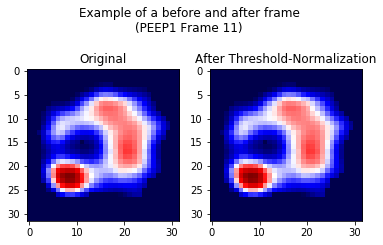

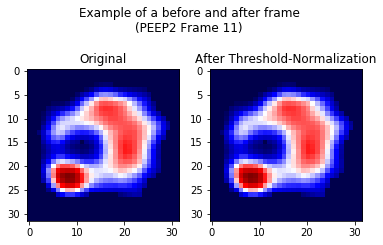

In [9]:
#finding the quantiles
for i in range(2):
    if i==0:
        q1 = np.quantile(PEEP1,0.01)
        q99 = np.quantile(PEEP1,0.99)
    else:
        if np.quantile(PEEP2,0.01) < q1:
            q1 = np.quantile(PEEP2,0.01)
        if np.quantile(PEEP2,0.99) > q99:
            q99 = np.quantile(PEEP2,0.99)
    print(f'iter_{i}: Q1:{q1} Q99:{q99}')
#computing the value's range
var_range = abs(q1)+abs(q99)
print('Values to consider for all PEEP levels:')
print(f'Q1 = {q1}\nQ99 = {q99}\nAbs_Range =  {var_range}\n\n')
print('Before Thresholding:')
print(f'PEEP1_Max = {PEEP1.max()}\nPEEP1_Min = {PEEP1.min()}\n')
print(f'PEEP2_Max = {PEEP2.max()}\nPEEP2_Min = {PEEP2.min()}\n')
# Threshold to values between Q1 and Q99
PEEP1_thresh = np.clip(PEEP1.copy(), q1, q99)
PEEP2_thresh = np.clip(PEEP2.copy(), q1, q99)
print('After Thresholding:')
print(f'PEEP1_Max = {PEEP1_thresh.max()}\nPEEP1_Min = {PEEP1_thresh.min()}\n')
print(f'PEEP2_Max = {PEEP2_thresh.max()}\nPEEP2_Min = {PEEP2_thresh.min()}\n')
#normalize through division of every value by range
PEEP1_norm = (PEEP1_thresh.copy()-q1)/var_range
PEEP2_norm = (PEEP2_thresh.copy()-q1)/var_range
print('After Normalizing:')
print(f'PEEP_Norm1_Max = {PEEP1_norm.max()}\nPEEP_Norm1_Min = {PEEP1_norm.min()}\n')
print(f'PEEP_Norm2_Max = {PEEP2_norm.max()}\nPEEP_Norm2_Min = {PEEP2_norm.min()}\n')

plt.figure(1)
plt.suptitle('Example of a before and after frame\n(PEEP1 Frame 11)')
plt.subplot(121)
plt.imshow(np.reshape(PEEP1[10],(32,32)))
plt.title('Original')
plt.set_cmap('seismic')
plt.subplot(122)
plt.imshow(np.reshape(PEEP1_norm[10],(32,32)))
plt.title('After Threshold-Normalization')
plt.set_cmap('seismic')

plt.figure(2)
plt.suptitle('Example of a before and after frame\n(PEEP2 Frame 11)')
plt.subplot(121)
plt.imshow(np.reshape(PEEP2[10],(32,32)))
plt.title('Original')
plt.set_cmap('seismic')
plt.subplot(122)
plt.imshow(np.reshape(PEEP2_norm[10],(32,32)))
plt.title('After Threshold-Normalization')
plt.set_cmap('seismic')

### 4th Step - Test Differentiation:
1) find 1st frame and pass the rest of the iteration;
2) Compute the differrence in pixel value of the remainder frames with the previous one;


In [10]:
data_diff = np.copy(PEEP1)
#Compute the differentiation between 2 consecutive images and extract features
for j in range(PEEP1.shape[0]):
    if j==0:
        img1=PEEP1[i]
        continue
    img2=np.copy(img1)
    img1=PEEP1[i]

    data_diff[i] = img2-img1

## TEST 3

In [11]:
from helper_func import feature_extraction
import SimpleITK as sitk
from radiomics import featureextractor

In [12]:
lungshape = section[4][dict_var_section['lLungShape32']]
img1 = PEEP1[3]
img2 = PEEP1[7]
img3 = PEEP1[32]

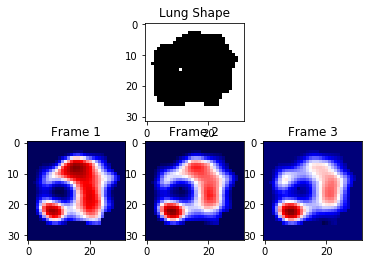

In [13]:
plt.figure
plt.subplot(232)
plt.imshow(np.reshape(lungshape,(32,32)))
plt.title('Lung Shape')
plt.set_cmap('Greys')
plt.subplot(234)
plt.imshow(np.reshape(img1,(32,32)))
plt.title('Frame 1')
plt.set_cmap('seismic')
plt.subplot(235)
plt.imshow(np.reshape(img2,(32,32)))
plt.title('Frame 2')
plt.set_cmap('seismic')
plt.subplot(236)
plt.imshow(np.reshape(img3,(32,32)))
plt.title('Frame 3')
plt.set_cmap('seismic')

In [14]:
lungshape = np.reshape(lungshape,(32,32))
lungshape = sitk.GetImageFromArray(lungshape)
img1 = np.reshape(img1,(32,32))
img1 = sitk.GetImageFromArray(img1)
img2 = np.reshape(img2,(32,32))
img2 = sitk.GetImageFromArray(img2)
img3 = np.reshape(img3,(32,32))
img3 = sitk.GetImageFromArray(img3)
img4 = sitk.GetImageFromArray(np.zeros((32,32)))
img5 = np.reshape(np.array([np.zeros(512),np.ones(512)]),(32,32))
img5 = sitk.GetImageFromArray(img5)

file_path = r'C:\Users\Vasco\Documents\Ms Data Science\3Semester\Code\EIT_CoViD_Internship'
params = os.path.join(file_path, "ParamsSettings_Pyradiomics_Params.yaml")
extractor = featureextractor.RadiomicsFeatureExtractor(params)

res1 = extractor.execute(img1,lungshape)
res2 = extractor.execute(img2,lungshape)
res3 = extractor.execute(img3,lungshape)
res4 = extractor.execute(img4,lungshape)
res5 = extractor.execute(img5,lungshape)

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


In [15]:
features = ["diagnostics_Mask-original_CenterOfMass",
"original_firstorder_Entropy",
"original_firstorder_Uniformity",
"original_firstorder_Variance",
"original_glcm_ClusterProminence",
"original_glcm_ClusterShade",
"original_glcm_Contrast",
"original_glrlm_GrayLevelNonUniformity",
"original_glrlm_GrayLevelVariance",
]

for i,res in enumerate([res1,res2,res3,res4,res5]):
    print(f'Frame {i+1}')
    for j in features:
        print(f'{j}: {np.round(res[j],6)}\n')
    print('===============================================================')


Frame 1
diagnostics_Mask-original_CenterOfMass: [15.193916 15.      ]

original_firstorder_Entropy: 1.563668

original_firstorder_Uniformity: 0.359055

original_firstorder_Variance: 0.0

original_glcm_ClusterProminence: 7.953885

original_glcm_ClusterShade: 0.574347

original_glcm_Contrast: 0.250447

original_glrlm_GrayLevelNonUniformity: 59.109277

original_glrlm_GrayLevelVariance: 0.552604

Frame 2
diagnostics_Mask-original_CenterOfMass: [15.193916 15.      ]

original_firstorder_Entropy: 3.935737

original_firstorder_Uniformity: 0.070046

original_firstorder_Variance: 1.7e-05

original_glcm_ClusterProminence: 8162.919406

original_glcm_ClusterShade: 92.644963

original_glcm_Contrast: 3.920588

original_glrlm_GrayLevelNonUniformity: 30.390433

original_glrlm_GrayLevelVariance: 15.841238

Frame 3
diagnostics_Mask-original_CenterOfMass: [15.193916 15.      ]

original_firstorder_Entropy: 4.978991

original_firstorder_Uniformity: 0.03512

original_firstorder_Variance: 7.4e-05

original_

Text(0.5, 1.0, 'Intensities Histogram')

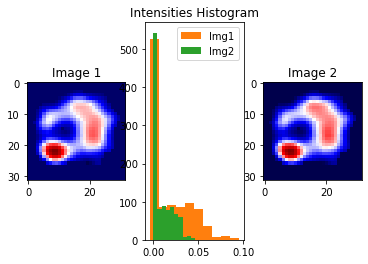

In [16]:
img1 = np.reshape(PEEP1[20],(32,32))
img2 = np.reshape(PEEP1[11],(32,32))
plt.figure
plt.subplot(131)
plt.imshow(img1)
plt.set_cmap('seismic')
plt.title('Image 1')
plt.subplot(133)
plt.imshow(img2)
plt.set_cmap('seismic')
plt.title('Image 2')
plt.subplot(132)
plt.hist(np.reshape(img1,(1024,1)))
plt.title('Intensities Histogram')
plt.subplot(132)
plt.hist(np.reshape(img1,(1024,1)),label='Img1')
plt.hist(np.reshape(img2,(1024,1)),label='Img2')
plt.legend()
plt.title('Intensities Histogram')


## Optical Color Scale Flow Tests


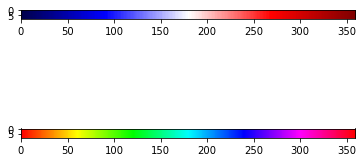

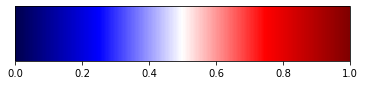

In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

angle = np.linspace(0,360,360)
angle = np.tile(angle,(10,1))

plt.figure
plt.subplot(211)
plt.imshow(angle)
plt.subplot(212)
final = np.ones((10,360,3))
final[:,:,0] = angle
final = final.astype('float32')
final = cv2.cvtColor(final,cv2.COLOR_HSV2RGB)
plt.imshow(final)

fig_scale, ax = plt.subplots(figsize=(6, 1))

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal')

## Feature Extration Tests (Feature Values evoultion)
Difference between batch values and 2 separate frames (from the batch) values

In [18]:
import pandas as pd
img1 = np.reshape(section[0][dict_var_section['dzMov']][0],(32,32)).copy()
img2 = np.reshape(section[0][dict_var_section['dzMov']][40],(32,32)).copy()
lung_Shape = np.reshape(section[0][dict_var_section['lLungShape32']],(32,32)).copy()

lung_Shape = sitk.GetImageFromArray(lung_Shape)
img1 = sitk.GetImageFromArray(img1)
img2 = sitk.GetImageFromArray(img2)

file_path = r'C:\Users\Vasco\Documents\Ms Data Science\3Semester\Code\EIT_CoViD_Internship'
params = os.path.join(file_path, "ParamsSettings_Pyradiomics_Params.yaml")

extractor = featureextractor.RadiomicsFeatureExtractor(params)

result1 = pd.Series(extractor.execute(img1,lung_Shape))
result2 = pd.Series(extractor.execute(img2,lung_Shape))

for k,v in result1.items():
    print(f'{k}: {v}')
print('################################')
for k,v in result2.items():
    print(f'{k}: {v}')

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
diagnostics_Versions_PyRadiomics: v3.0.1
diagnostics_Versions_Numpy: 1.18.1
diagnostics_Versions_SimpleITK: 2.0.0
diagnostics_Versions_PyWavelet: 1.1.1
diagnostics_Versions_Python: 3.7.6
diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': [1, 1], 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 10, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': [-3, 3], 'label': 1, 'additionalInfo': True, 'resegmentMode': 'sigma', 'voxelArrayShift': 10}
diagnostics_Configuration_EnabledImageTypes: {'Original': {'binWidth': 0.001}}
diagnostics_Image-original_Hash: 0631457264ff7f8d5fb1edc2c0211992a67c73e6
diagnostics_Image-original_Dimensionality: 2D
diagnostics_Ima

## Binary Mask treatment
Perform Dilation and erosion to remove eventual holes in the mask

Text(0.5, 1.0, 'Eroded/Final')

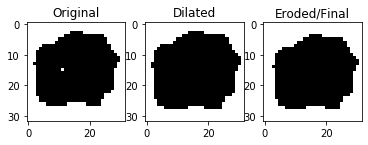

In [19]:
plt.figure
plt.set_cmap('Greys')
plt.subplot(131)
lung_Shape = np.reshape(section[0][dict_var_section['lLungShape32']],(32,32)).copy()
plt.imshow(lung_Shape)
plt.title('Original')
plt.subplot(132)
lung_Shape = cv2.dilate(lung_Shape, np.ones((2,2)))
plt.imshow(lung_Shape)
plt.title('Dilated')
plt.subplot(133)
lung_Shape = cv2.erode(lung_Shape, np.ones((2,2)))
plt.imshow(lung_Shape)
plt.title('Eroded/Final')